In [1]:
from transformers import AutoTokenizer, GPT2LMHeadModel, AutoConfig
import tiktoken
import torch
from torch.utils.data import DataLoader
import numpy as np
import json
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt

from utils import Library

In [2]:
data_file = 'gutenberg/books.bin'
auxdata_file = 'gutenberg/books_metadata.json'

data = np.memmap(data_file, dtype=np.uint16, mode='r')
auxdata = []
with open(auxdata_file, 'r') as file:
    for line in file:
        auxdata.append(json.loads(line))

In [3]:
def evaluate(model, eval_loader):
    model.eval()
    total_log_likelihood = 0.0
    total_tokens = 0

    for batch in eval_loader:
        X, Y = batch
        inputs = {
            'input_ids': X.to(1),
            'labels': Y.to(1)
        }

        with torch.no_grad():
            outputs = model(**inputs)
            loss = outputs.loss
        log_likelihood = -loss.item() * X.numel()
        total_log_likelihood += log_likelihood
        total_tokens += X.numel()

    avg_neg_log_likelihood = -total_log_likelihood / total_tokens

    try:
        perplexity = torch.exp(torch.tensor(avg_neg_log_likelihood))
    except OverflowError:
        perplexity = float('inf')
    return perplexity.item()

In [ ]:
# def compute_ppl(model, batch):
#     model.eval()
#     total_log_likelihood = 0.0
#     total_tokens = 0

#     X, Y = batch
#     inputs = {
#         'input_ids': X.to(1),
#         'labels': Y.to(1)
#     }

#     with torch.no_grad():
#         outputs = model(**inputs)
#         loss = outputs.loss
#     log_likelihood = -loss.item() * X.numel()
#     total_log_likelihood += log_likelihood
#     total_tokens += X.numel()

#     avg_neg_log_likelihood = -total_log_likelihood / total_tokens

#     try:
#         perplexity = torch.exp(torch.tensor(avg_neg_log_likelihood))
#     except OverflowError:
#         perplexity = float('inf')
#     return perplexity.item()

In [5]:
config = AutoConfig.from_pretrained("gpt2")
model = GPT2LMHeadModel(config)
model.to(1)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [6]:
library = Library(data, auxdata)

In [7]:
id = np.argmax(library.lengths_)
library.current = id
book = next(library)

In [8]:
batch_size = 8

data = book['train_data']    
dataloader = DataLoader(data, batch_size=batch_size, shuffle=False)

model.to(1)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

training_loss = []
perplexity = []

progress_bar = tqdm(enumerate(dataloader))

for k, batch in progress_bar:
    model.train()

    x, y = batch
    inputs = {
        'input_ids': x.to(1),
        'labels': y.to(1)
    }

    outputs = model(**inputs)
    loss = outputs.loss

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    tr_loss = loss.item()
    training_loss.append(tr_loss)

    # evaluate
    if k < len(dataloader)-2:
        remaining_data = torch.utils.data.Subset(data, range((k+1)*batch_size, len(data)))
    else:
        break

    # eval_loader = DataLoader(remaining_data, batch_size=batch_size, shuffle=False)
    # ppl = evaluate(model, eval_loader)
    ppl = compute_ppl(model, batch)
    perplexity.append(ppl)

    progress_bar.set_description(f"step [{k + 1}/{len(dataloader)}] - tr_loss: {tr_loss:.4f}, ppl: {ppl:.4f}")

0it [00:00, ?it/s]`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
step [15/92] - tr_loss: 5.2169, ppl: 0.0060: : 15it [00:17,  1.15s/it]


KeyboardInterrupt: 

In [14]:
loss.item()

5.150663375854492

In [17]:
torch.exp(torch.tensor(loss.item()))

tensor(172.5459)

In [11]:
x.numel()

8192

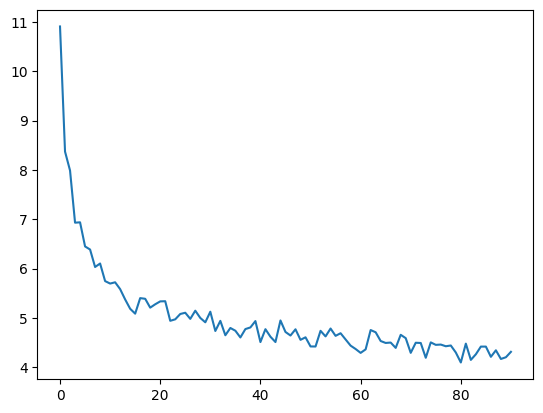

In [ ]:
plt.plot(training_loss)

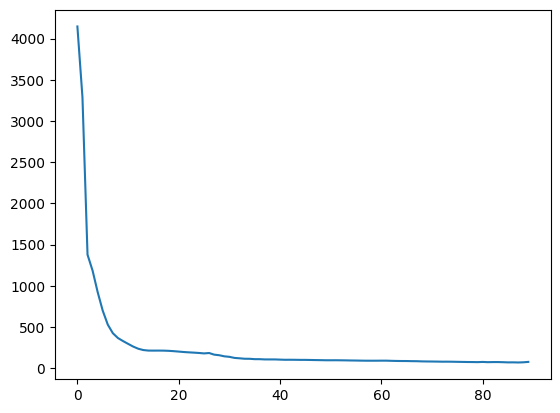

In [ ]:
plt.plot(perplexity)

In [7]:
library.reset()

model.to(1)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

training_loss = []
perplexity = []

progress_bar = tqdm(enumerate(library), total=len(library), unit='book')
ppl = float('inf')


for book_id, book in progress_bar:
    if book_id == len(library)-1:
        break

    # print(f"Training on book {book_id}: {book['metadata']['title']}")

    train_data = book['train_data']    
    train_loader = DataLoader(train_data, batch_size=8, shuffle=False)
    
    # num_blocks = len(X)
    # block_indices = np.arange(num_blocks)
    # batch_indices = [block_indices[i:min(i + batch_size, num_blocks)] for i in range(0, num_blocks, batch_size)]

    model.train()

    for k, batch in enumerate(train_loader):
    
        # X_batch = torch.stack([X[i] for i in ids]).to(1)
        # Y_batch = torch.stack([Y[i] for i in ids]).to(1)

        x, y = batch

        inputs = {
            'input_ids': x.to(1),
            'labels': y.to(1)
        }

        outputs = model(**inputs)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        tr_loss = loss.item()
        training_loss.append(tr_loss)
        progress_bar.set_description(f"step [{k + 1}/{len(train_loader)}] - tr_loss: {tr_loss:.4f}, ppl: {ppl:.4f}")

    eval_data = book['eval_data']
    eval_loader = DataLoader(eval_data, batch_size=16, shuffle=False)
    ppl = evaluate(model, eval_loader)
    perplexity.append(ppl)
    progress_bar.set_description(f"step [{k + 1}/{len(train_loader)}] - tr_loss: {tr_loss:.4f}, ppl: {ppl:.4f}")

step [1/9] - tr_loss: 6.2975, ppl: 617.6099:   3%|▎         | 11/355 [01:10<36:53,  6.43s/book]    


KeyboardInterrupt: 